In [1]:
import pathlib

# data
import xarray
import numpy as np
import pandas as pd

# plotting
import cmocean.cm
import matplotlib
import matplotlib.pyplot as plt
import osgeo.osr

# 3d
from tvtk.api  import tvtk
from mayavi import mlab


In [18]:
ds_path = pathlib.Path('~/data/odv/climatology/SDN_MedSea_Clim.nc').expanduser()
ds_path = pathlib.Path('~/data/odv/climatology/Water_body_Salinity_NorthSea.4Danl_monthly.nc').expanduser()

wgs84 = osgeo.osr.SpatialReference()
webmercator = osgeo.osr.SpatialReference()
wgs84.ImportFromEPSG(4326)
webmercator.ImportFromEPSG(3857)
wgs2wm =  osgeo.osr.CoordinateTransformation(wgs84, webmercator)

In [19]:
ds = xarray.open_dataset(ds_path)
ds

<xarray.Dataset>
Dimensions:             (depth: 41, lat: 109, lon: 113, nv: 2, observations: 7680899, time: 12)
Coordinates:
  * lon                 (lon) float64 -4.0 -3.875 -3.75 ... 9.75 9.875 10.0
  * lat                 (lat) float64 48.5 48.62 48.75 ... 61.75 61.88 62.0
  * depth               (depth) float64 0.0 5.0 10.0 15.0 ... 600.0 650.0 700.0
  * time                (time) datetime64[ns] 1984-01-16 ... 1984-12-16
    obslon              (observations) float32 ...
    obslat              (observations) float32 ...
    obstime             (observations) datetime64[ns] ...
    obsdepth            (observations) float32 ...
Dimensions without coordinates: nv, observations
Data variables:
    climatology_bounds  (time, nv) datetime64[ns] ...
    Salinity            (time, depth, lat, lon) float32 ...
    Salinity_L1         (time, depth, lat, lon) float32 ...
    Salinity_L2         (time, depth, lat, lon) float32 ...
    Salinity_relerr     (time, depth, lat, lon) float32 ...
    obsid               (observations) |S69 ...
Attributes:
    Conventions:            CF-1.6
    title:                  DIVA 4D analysis of sea water salinity
    file_name:              Water_body_Salinity_NorthSea.4Danl_monthly.nc
    product_id:             e0e2e8f6-8ee7-11e9-00d2-eb5439de70e8
    date:                   2019-06-14T23:03:37
    project:                SeaDataCloud
    institution:            Royal Belgian Institute of Natural Sciences, Oper...
    institution_urn:        SDN:EDMO::3330
    production:             DIVA group
    Author_e-mail:          Serge Scory <sscory@naturalsciences.be>
    source:                 Observational data from SeaDataNet
    comment:                Only one dataset considered (SeaDataCloud V1 disc...
    parameter_keyword:      Water body salinity
    parameter_keyword_urn:  SDN:P35::EPC00001
    search_keywords:        Salinity of the water column
    search_keywords_urn:    SDN:P02::PSAL
    area_keywords:          North Sea, English Channel
    area_keywords_urn:      SDN:C19::1_2, SDN:C19::1_7
    product_code:           something-to-decide
    product_version:        1.0
    bathymetry_source:      The GEBCO Digital Atlas published by the British ...
    abstract:               ...
    acknowledgement:        ...
    documentation:          http://dx.doi.org/doi_of_doc
    doi:                    ...
    data_access:            http://sdn.oceanbrowser.net/data/SeaDataCloud-dom...
    WEB_visualisation:      http://sdn.oceanbrowser.net/web-vis/

In [9]:
def compute_contours(ds_path):
    """compute a set  of contours for a dataset"""
    ds = xarray.open_dataset(ds_path)
    ds = ds.isel(time=1)

    meta = {}

    arr = np.squeeze(ds.Salinity.values)

    temp_min = np.nanmin(arr)
    temp_max = np.nanmax(arr)

    q = [0.01, 0.05, 0.1, 0.25,  0.5,  0.75, 0.9, 0.95,  0.99]
    percentiles = np.nanpercentile(arr, q)
    
    # percentiles = np.array([6, 8,  10, 12, 14, 16.0])

    meta['temp_min'] = temp_min
    meta['temp_max'] = temp_max
    meta['percentiles'] = percentiles.tolist()

    # change dimenions  to x,y,z
    arr = np.moveaxis(arr, [0, 1, 2], [2, 1, 0])

    arr_masked = np.ma.masked_invalid(arr)
    arr_filled = arr_masked.filled(0).copy()

    Lat, Lon, Z = np.meshgrid(ds.lat.values, ds.lon.values, ds.depth.values)
    xyz = np.array(wgs2wm.TransformPoints(np.c_[Lat.ravel(), Lon.ravel()]))
    X =  xyz[:, 0].reshape(Lon.shape)
    Y =  xyz[:, 1].reshape(Lat.shape)
    
    x_min, x_max = X.min(), X.max()
    y_min, y_max = Y.min(), Y.max()
    z_min, z_max = Z.min(), Z.max()
    
    lat_min, lat_max = Lat.min(), Lat.max()
    lon_min, lon_max = Lon.min(), Lon.max()
    
    meta['x_min'] = x_min
    meta['x_max'] = x_max
    meta['y_min'] = y_min
    meta['y_max'] = y_max
    meta['z_min'] = z_min
    meta['z_max'] = z_max
    meta['lat_min'] = lat_min
    meta['lat_max'] = lat_max
    meta['lon_min'] = lon_min
    meta['lon_max'] = lon_max
    
    
    isos = [
        mlab.contour3d(X, Y, Z, arr_filled,  contours=[percentile])
        for percentile
        in percentiles
    ]
    meta['isos'] = isos

    contours = []
    for iso in isos:
        contour = iso.contour
        contour.minimum_contour = temp_min
        contour.filled_contours = False
        contour.outputs[0].update()
        contours.append(contour.outputs[0].output)
    return meta, contours

In [10]:
meta, contours =  compute_contours(ds_path)



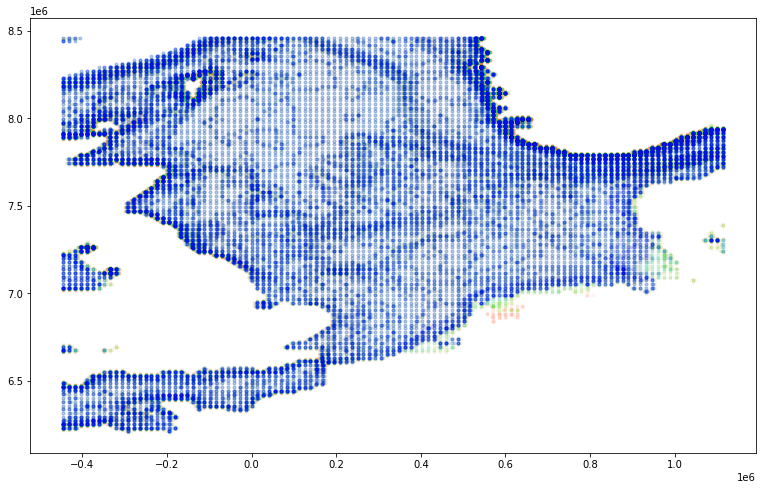

In [11]:
N = matplotlib.colors.Normalize(meta['temp_min'], meta['temp_max'])
colors = matplotlib.cm.hsv(N(meta['percentiles']))

fig, ax = plt.subplots(figsize=(13, 8))
for color, contour, percentile in list(zip(colors, contours, meta['percentiles'])):
    df =  pd.DataFrame(contour.points, columns=['x', 'y', 'z'])
    ax.plot(df.x, df.y, '.', alpha=0.04, color=color)

In [6]:
df.head()

,x,y,z
0,3729203.00,3953726.25,4997.548828
1,3743118.00,3953726.25,4977.534180
2,3757032.75,3953726.25,4973.404297
3,3770947.75,3953726.25,4984.981934
4,3729203.00,3969803.75,4974.854492


In [29]:
for i, (color, contour, percentile) in enumerate(zip(colors, contours, meta['percentiles'])):
    
    smooth = tvtk.SmoothPolyDataFilter()
    smooth.relaxation_factor  = 0.01
    smooth.add_input_data_object(contour)
    smooth.update()
    
    transform_filter = tvtk.TransformFilter()
    transform = tvtk.Transform()
    x_min = meta['x_min']
    x_max = meta['x_max']
    y_min = meta['y_min']
    y_max = meta['y_max']
    z_min = meta['z_min']
    z_max = meta['z_max']
    lat_min = meta['lat_min'] 
    lat_max = meta['lat_max'] 
    lon_min = meta['lon_min'] 
    lon_max = meta['lon_max'] 

    transform.scale(1/(x_max - x_min), 1/(y_max - y_min), 1/(z_max - z_min))
    transform_filter.transform = transform
    transform_filter.add_input_data_object(smooth.output)
    transform_filter.update()
    
    
#     decimate = tvtk.DecimatePro()
#     decimate.add_input_data_object(smooth.output)
#     decimate.update()

    writer = tvtk.PLYWriter(file_name='polydata-{:04d}-{}.ply'.format(i, percentile))
#     writer.add_input_data_object(decimate.output)
    writer.add_input_data_object(transform_filter.output)
    
    writer.update()
    writer.write()

In [8]:
!open  .

In [27]:
transform_filter.transform

In [1]:
!ls *.ply

polydata-0000-6.0.ply  polydata-0002-10.0.ply polydata-0004-14.0.ply
polydata-0001-8.0.ply  polydata-0003-12.0.ply polydata-0005-16.0.ply
